In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage import io
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical

## Loading the data

In [3]:
# jika data disimpan dalam numpy compressed
# (misalnya) np.savez_compressed('results/all_data_images_overlap_0.5.npz', all_images)
# maka diimport (load) demgan cara berikut:

all_images = np.load('results/all_data_images_overlap_0.5.npz')['arr_0']
all_masks = np.load('results/all_data_masks_overlap_0.5.npz')['arr_0']
all_labels = np.load('results/all_data_labels_overlap_0.5.npz')['arr_0']

In [4]:
print(all_images.shape)
print(all_masks.shape)
print(all_labels.shape)

(5839, 256, 256, 3)
(5839, 256, 256, 4)
(5839, 256, 256, 1)


### Ubah ke Categorical

In [5]:
all_cats = to_categorical(all_labels, num_classes=5)

In [6]:
all_cats.shape

(5839, 256, 256, 5)

Class yang ada dalam Cell:  [0. 1. 2.]


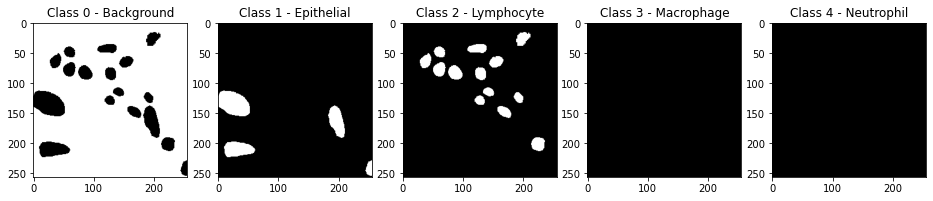

In [7]:
cek_ind=0
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.imshow(all_cats[cek_ind][:,:,0], cmap='gray');
plt.title('Class 0 - Background')
plt.subplot(1,5,2)
plt.imshow(all_cats[cek_ind][:,:,1], cmap='gray');
plt.title('Class 1 - Epithelial')
plt.subplot(1,5,3)
plt.imshow(all_cats[cek_ind][:,:,2], cmap='gray');
plt.title('Class 2 - Lymphocyte')
plt.subplot(1,5,4)
plt.imshow(all_cats[cek_ind][:,:,3], cmap='gray');
plt.title('Class 3 - Macrophage')
plt.subplot(1,5,5)
plt.imshow(all_cats[cek_ind][:,:,4], cmap='gray');
plt.title('Class 4 - Neutrophil')

print("Class yang ada dalam Cell: ", np.unique(all_labels[cek_ind]))

### Prepare Training, Validation Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_cats, test_size=0.2, random_state=0)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [10]:
print("Data latih: ", X_train.shape)
print("Data validasi: ", X_val.shape)
print("Data uji: ", X_test.shape)

print("Label data latih:", y_train.shape)
print("Label data validasi:", y_val.shape)
print("Label data uji:", y_test.shape)

Data latih:  (4671, 256, 256, 3)
Data validasi:  (584, 256, 256, 3)
Data uji:  (584, 256, 256, 3)
Label data latih: (4671, 256, 256, 5)
Label data validasi: (584, 256, 256, 5)
Label data uji: (584, 256, 256, 5)


## Model CNN
### Convolutional Blocks

In [11]:
def down_block(x, filters, kernel_size=(3, 3), init='he_normal', padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), init='he_normal', padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), init='he_normal', padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation="relu")(c)
    c = keras.layers.Dropout(0.25)(c) # ditambahi dropout
    return c

### UNet Model

In [12]:
def create_unet(image_size=256, n_class=5, filters = [16, 32, 64, 128, 256]): # original model: filters = [64, 128, 256, 512, 1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) 
    c2, p2 = down_block(p1, filters[1]) 
    c3, p3 = down_block(p2, filters[2]) 
    c4, p4 = down_block(p3, filters[3]) 
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3]) 
    u2 = up_block(u1, c3, filters[2]) 
    u3 = up_block(u2, c2, filters[1]) 
    u4 = up_block(u3, c1, filters[0])
    
    outputs = keras.layers.Conv2D(n_class, (1, 1), padding="same", activation='softmax')(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [13]:
model = create_unet(filters = [32, 64, 128, 256, 512])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Train the Model

In [15]:
epochs = 20
batch_size = 4
lr = 1e-4
x_axis_inc = 1

In [16]:
def plot_history(sejarah, fig_train, epochs, subtitle, acc_ylim = 1, loss_ylim=1.2, figsize=(14, 4), x_axis_inc=1):
    epoch_list = list(range(1,epochs+1))
    y_train_acc = sejarah.history['accuracy'] # binary_accuracy  accuracy
    y_val_acc = sejarah.history['val_accuracy'] # val_binary_accuracy  val_accuracy
    y_train_loss = sejarah.history['loss']
    y_val_loss = sejarah.history['val_loss']
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    t = f.suptitle(subtitle, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    ax1.plot(epoch_list, y_train_acc, label='Train Accuracy')
    ax1.plot(epoch_list, y_val_acc, label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax1.set_ylim(0.2,acc_ylim)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, y_train_loss, label='Train Loss')
    ax2.plot(epoch_list, y_val_loss, label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax2.set_ylim(0,loss_ylim)
    ax2.set_ylabel('Cross Entropy')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    plt.savefig(fig_train)

In [17]:
fig_train = 'results/monusac_unet_filter32_ov5'
log_file = 'results/monusac_unet_filter32_ov5.csv'
model_path = 'results/monusac_unet_filter32_ov5.h5'
sub_title = 'Multi-organ Nuclei Segmentation using UNet'

In [18]:
# Jangan lupa meng-compile setiap kali mengubah struktur atau parameter model
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=lr),
              metrics=["accuracy"])

In [19]:
callbacks = [CSVLogger(log_file),  ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)]

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/20
1168/1168 [==============================] - 54s 43ms/step - loss: 1.4790 - accuracy: 0.8281 - val_loss: 0.5598 - val_accuracy: 0.8447
Epoch 2/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.4803 - accuracy: 0.8687 - val_loss: 0.4107 - val_accuracy: 0.8668
Epoch 3/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.3505 - accuracy: 0.8894 - val_loss: 0.3132 - val_accuracy: 0.8973
Epoch 4/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.2921 - accuracy: 0.9023 - val_loss: 0.2525 - val_accuracy: 0.9130
Epoch 5/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.2536 - accuracy: 0.9117 - val_loss: 0.2379 - val_accuracy: 0.9168
Epoch 6/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.2256 - accuracy: 0.9193 - val_loss: 0.2152 - val_accuracy: 0.9214
Epoch 7/20
1168/1168 [==============================] - 49s 42ms/step - loss: 0.2014 - accuracy: 0.9260 - val_loss: 0.1748 -

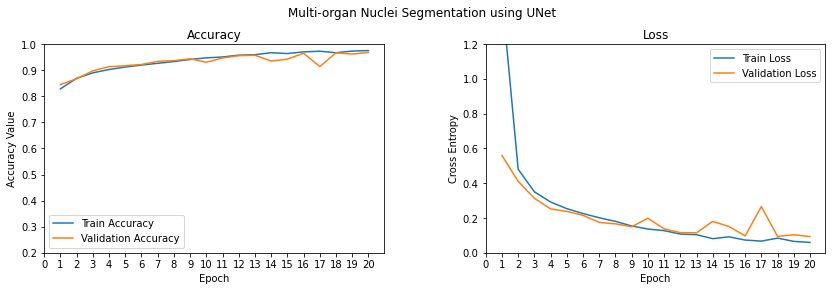

In [21]:
plot_history(history, fig_train, epochs, sub_title)

### Inference Process

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# Use this code if you just run the notebook for the inferences process
# If you train the model from the beginning, you can do the inferences directly without running this line code
new_model = tf.keras.models.load_model(model_path)

In [22]:
# Lakukan prediksi untuk testing data
y_test_predict = model.predict(X_test)

In [23]:
y_test_predict.shape

(584, 256, 256, 5)

Testing index = 119


Text(0.5, 1.0, 'Class 4 - Neutrophil')

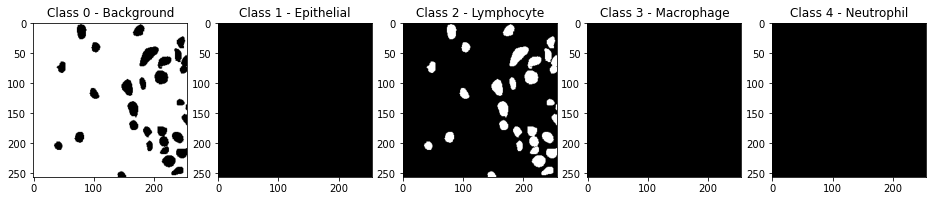

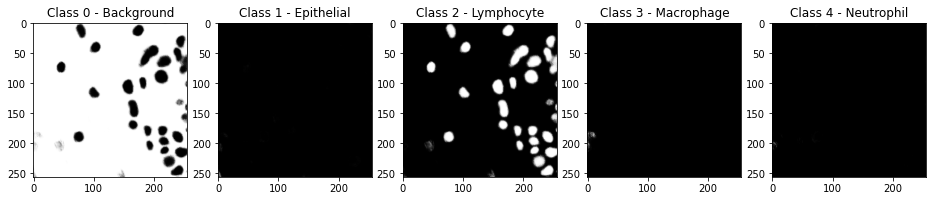

In [24]:
ind_test = random.randint(0, X_test.shape[0]-1)
print("Testing index =", ind_test)

# Ground Truth
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.imshow(y_test[ind_test][:,:,0], cmap='gray');
plt.title('Class 0 - Background')

plt.subplot(1,5,2)
plt.imshow(y_test[ind_test][:,:,1], cmap='gray');
plt.title('Class 1 - Epithelial')

plt.subplot(1,5,3)
plt.imshow(y_test[ind_test][:,:,2], cmap='gray');
plt.title('Class 2 - Lymphocyte')

plt.subplot(1,5,4)
plt.imshow(y_test[ind_test][:,:,3], cmap='gray');
plt.title('Class 3 - Macrophage')

plt.subplot(1,5,5)
plt.imshow(y_test[ind_test][:,:,4], cmap='gray');
plt.title('Class 4 - Neutrophil')

# Prediction
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.imshow(y_test_predict[ind_test][:,:,0], cmap='gray');
plt.title('Class 0 - Background')

plt.subplot(1,5,2)
plt.imshow(y_test_predict[ind_test][:,:,1], cmap='gray');
plt.title('Class 1 - Epithelial')

plt.subplot(1,5,3)
plt.imshow(y_test_predict[ind_test][:,:,2], cmap='gray');
plt.title('Class 2 - Lymphocyte')

plt.subplot(1,5,4)
plt.imshow(y_test_predict[ind_test][:,:,3], cmap='gray');
plt.title('Class 3 - Macrophage')

plt.subplot(1,5,5)
plt.imshow(y_test_predict[ind_test][:,:,4], cmap='gray');
plt.title('Class 4 - Neutrophil')

In [25]:
np.savez_compressed('results/unet32_predict_test_ov5.npz', y_test_predict)